In [1]:
import zstandard as zstd
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import numpy as np
import pickle

In [2]:
def lzw_compress(uncompressed: str) -> list:
    """Compress a string to a list of output symbols using LZW."""
    dict_size = 256
    dictionary = {chr(i): i for i in range(dict_size)}
    w = ""
    result = []

    for c in uncompressed:
        wc = w + c
        if wc in dictionary:
            w = wc
        else:
            result.append(dictionary[w])
            dictionary[wc] = dict_size
            dict_size += 1
            w = c
    if w:
        result.append(dictionary[w])
    return result

In [3]:
def lzw_decompress(compressed: list) -> str:
    """Decompress a list of output symbols to a string."""
    dict_size = 256
    dictionary = {i: chr(i) for i in range(dict_size)}
    result = []

    w = chr(compressed.pop(0))
    result.append(w)

    for k in compressed:
        if k in dictionary:
            entry = dictionary[k]
        elif k == dict_size:
            entry = w + w[0]
        else:
            raise ValueError("Bad compressed k: %s" % k)
        result.append(entry)
        dictionary[dict_size] = w + entry[0]
        dict_size += 1
        w = entry

    return "".join(result)

In [4]:
def compress_csv_zstd(input_file, compressed_file):
    df = pd.read_csv(input_file)
    data = df.to_csv(index=False).encode('utf-8')

    compressor = zstd.ZstdCompressor(level=5)

    start_time = time.time()
    compressed_data = compressor.compress(data)
    compression_time = time.time() - start_time

    with open(compressed_file, 'wb') as f_out:
        f_out.write(compressed_data)

    return len(data), len(compressed_data), compression_time

In [5]:
def decompress_csv_zstd(compressed_file, output_file):
    with open(compressed_file, 'rb') as f_in:
        compressed_data = f_in.read()

    decompressor = zstd.ZstdDecompressor()

    start_time = time.time()
    decompressed_data = decompressor.decompress(compressed_data)
    decompression_time = time.time() - start_time

    decompressed_text = decompressed_data.decode('utf-8')
    with open(output_file, 'w', encoding='utf-8') as f_out:
        f_out.write(decompressed_text)

    return len(decompressed_data), decompression_time

In [6]:
def compress_csv_lzw(input_file, compressed_file):
    df = pd.read_csv(input_file)
    csv_data = df.to_csv(index=False)

    start_time = time.time()
    compressed_data = lzw_compress(csv_data)
    compression_time = time.time() - start_time

    with open(compressed_file, "wb") as f:
        pickle.dump(compressed_data, f)

    original_size = len(csv_data.encode("utf-8"))
    compressed_size = os.path.getsize(compressed_file)
    return original_size, compressed_size, compression_time

In [7]:
def decompress_csv_lzw(compressed_file, decompressed_file):
    start_time = time.time()
    with open(compressed_file, "rb") as f:
        compressed_data = pickle.load(f)

    decompressed_text = lzw_decompress(compressed_data.copy())
    decompression_time = time.time() - start_time

    with open(decompressed_file, "w", encoding="utf-8") as f:
        f.write(decompressed_text)

    return len(decompressed_text.encode("utf-8")), decompression_time

Running LZW (Existing) compression...
Running LZW (Existing) decompression...
LZW run complete.

Running Zstd (Proposed) compression...
Running Zstd (Proposed) decompression...
Zstd run complete.


--- COMPARATIVE RESULTS ---
    Methodology Compression Ratio Compression Time (s) Decompression Time (s)  Original Size (bytes)  Compressed Size (bytes)
 LZW (Existing)              1.58              13.7955                 4.2716               38485859                 24407004
Zstd (Proposed)              2.64               0.6227                 0.1120               38485859                 14582805


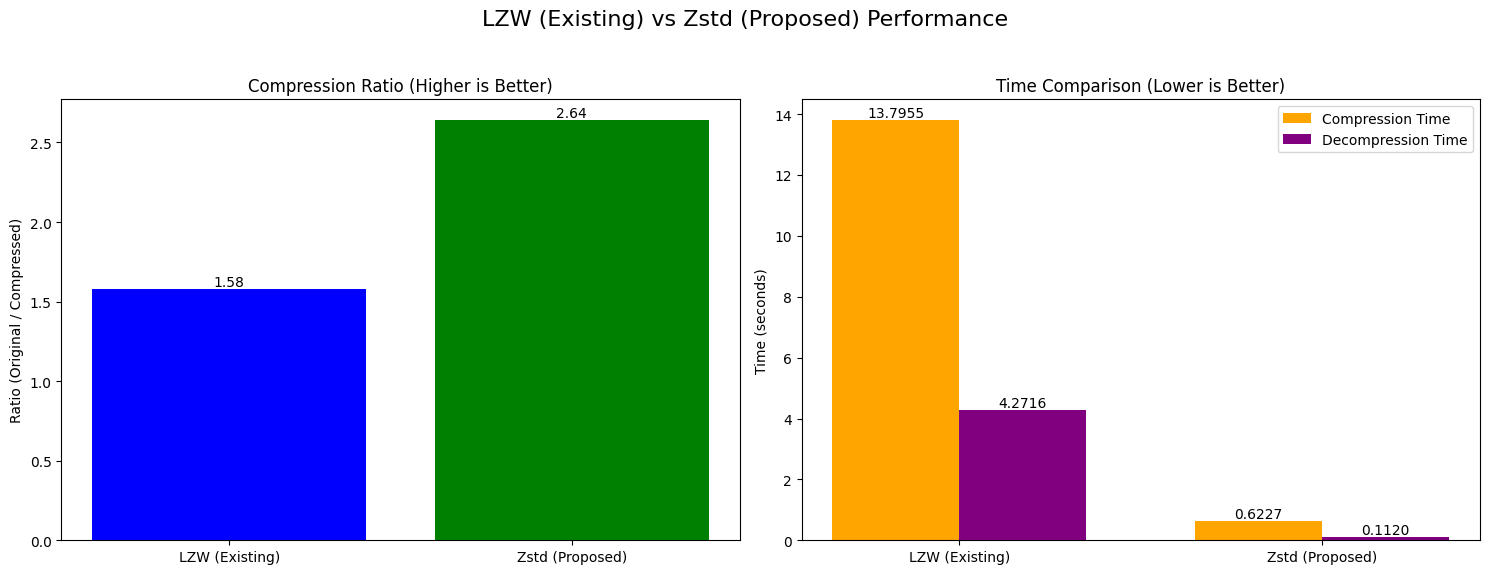


Cleaning up generated files...
Cleanup complete.


In [8]:
def main():
    input_file = "human_vital_signs_dataset_2024.csv"

    if not os.path.exists(input_file):
        print(f"Error: Input file '{input_file}' not found.")
        print("Please place the dataset in this directory.")
        return

    # File names
    lzw_compressed_file = "compressed_dataset.lzw"
    lzw_decompressed_file = "decompressed_dataset_lzw.csv"

    zstd_compressed_file = "compressed_dataset.zst"
    zstd_decompressed_file = "decompressed_dataset_zstd.csv"

    results = {}

    # --- LZW (Existing) ---
    print("Running LZW (Existing) compression...")
    lzw_orig_size, lzw_comp_size, lzw_comp_time = compress_csv_lzw(input_file, lzw_compressed_file)
    lzw_ratio = lzw_orig_size / lzw_comp_size if lzw_comp_size != 0 else 0

    print("Running LZW (Existing) decompression...")
    lzw_decomp_size, lzw_decomp_time = decompress_csv_lzw(lzw_compressed_file, lzw_decompressed_file)
    print("LZW run complete.")

    results['lzw'] = {
        "Methodology": "LZW (Existing)",
        "Compression Ratio": lzw_ratio,
        "Compression Time (s)": lzw_comp_time,
        "Decompression Time (s)": lzw_decomp_time,
        "Original Size (bytes)": lzw_orig_size,
        "Compressed Size (bytes)": lzw_comp_size
    }

    # --- Zstd (Proposed) ---
    print("\nRunning Zstd (Proposed) compression...")
    zstd_orig_size, zstd_comp_size, zstd_comp_time = compress_csv_zstd(input_file, zstd_compressed_file)
    zstd_ratio = zstd_orig_size / zstd_comp_size if zstd_comp_size != 0 else 0

    print("Running Zstd (Proposed) decompression...")
    zstd_decomp_size, zstd_decomp_time = decompress_csv_zstd(zstd_compressed_file, zstd_decompressed_file)
    print("Zstd run complete.")

    results['zstd'] = {
        "Methodology": "Zstd (Proposed)",
        "Compression Ratio": zstd_ratio,
        "Compression Time (s)": zstd_comp_time,
        "Decompression Time (s)": zstd_decomp_time,
        "Original Size (bytes)": zstd_orig_size,
        "Compressed Size (bytes)": zstd_comp_size
    }

    # --- Results Table ---
    results_df = pd.DataFrame([results['lzw'], results['zstd']])
    results_df['Compression Ratio'] = results_df['Compression Ratio'].map('{:.2f}'.format)
    results_df['Compression Time (s)'] = results_df['Compression Time (s)'].map('{:.4f}'.format)
    results_df['Decompression Time (s)'] = results_df['Decompression Time (s)'].map('{:.4f}'.format)

    print("\n\n--- COMPARATIVE RESULTS ---")
    print(results_df.to_string(index=False))

    # --- Visualization ---
    labels = [results['lzw']['Methodology'], results['zstd']['Methodology']]
    ratios = [float(results['lzw']['Compression Ratio']), float(results['zstd']['Compression Ratio'])]
    comp_times = [results['lzw']['Compression Time (s)'], results['zstd']['Compression Time (s)']]
    decomp_times = [results['lzw']['Decompression Time (s)'], results['zstd']['Decompression Time (s)']]

    plt.figure(figsize=(15, 6))

    # Plot 1: Compression Ratio
    plt.subplot(1, 2, 1)
    bars_ratio = plt.bar(labels, ratios, color=['blue', 'green'])
    plt.title('Compression Ratio (Higher is Better)')
    plt.ylabel('Ratio (Original / Compressed)')
    plt.bar_label(bars_ratio, fmt='%.2f')

    # Plot 2: Time Comparison (Grouped Bars)
    plt.subplot(1, 2, 2)
    x = np.arange(len(labels))
    width = 0.35

    rects1 = plt.bar(x - width/2, comp_times, width, label='Compression Time', color='orange')
    rects2 = plt.bar(x + width/2, decomp_times, width, label='Decompression Time', color='purple')

    plt.title('Time Comparison (Lower is Better)')
    plt.ylabel('Time (seconds)')
    plt.xticks(x, labels)
    plt.legend()
    plt.bar_label(rects1, fmt='%.4f')
    plt.bar_label(rects2, fmt='%.4f')

    plt.suptitle('LZW (Existing) vs Zstd (Proposed) Performance', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # --- Cleanup ---
    print("\nCleaning up generated files...")
    for file in [lzw_compressed_file, lzw_decompressed_file, zstd_compressed_file, zstd_decompressed_file]:
        if os.path.exists(file):
            os.remove(file)
    print("Cleanup complete.")


if __name__ == "__main__":
    main()